# HW 4 Set 1 - Problem 1 (Prox)

Consider the function $p:\mathbb{R}^{3\times 4}\to\mathbb{R}$ given by:
$$p(X)=||X||_*, X\in \mathbb{R}^{3\times 4}.$$

Write a Python function to find $\textrm{prox}_{\mu p}(X),$ where $\mu>0$ and $X$ are inputs of the function.

In [3]:
import numpy as np

In [14]:
def prox_nuclear_norm(X, mu):
    # Perform SVD
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    
    # construct v
    v = np.zeros(len(S))
    for i in range (len(S)):
        if (S[i] < (-1)*mu):
            v[i] = S[i] + mu
        if (S[i] > mu):
            v[i] = S[i] - mu
        else:
            v[i] = 0
    
    # Reconstruct the matrix 
    return U @ np.diag(v) @ Vt

Use the function in part (a) to find $\textrm{prox}_{\mu p}(X)$ for the case where $\mu=\frac{1}{2}$ and $X\in \mathbb{R}^{3\times 4}$ consists of all ones.

In [15]:
# Define the matrix X and parameter mu
X = np.ones((3, 4))
mu = 0.5

# Compute the prox
prox_result = prox_nuclear_norm(X, mu)

# Print the result
prox_result

array([[0.85566243, 0.85566243, 0.85566243, 0.85566243],
       [0.85566243, 0.85566243, 0.85566243, 0.85566243],
       [0.85566243, 0.85566243, 0.85566243, 0.85566243]])

# HW 4 Set 1 - Problem 2 (Accel. Gradient)

Given the matrix below with three missing entries:
$$M=\begin{bmatrix}
    \textrm{NaN} & 0.38119569 &-0.23319457  & 0.26949725 & -0.23018613 & \textrm{NaN} \\
    -0.21834876 & -0.10610883 & 0.06491155 & -0.07501669 & 0.06407412 & 0.0643938 \\
    1.02283804 & 0.49705868 & -0.30407318 & 0.35140992 & -0.30015033 & -0.30164782 \\
    2.40518827 & 1.16882601 & \textrm{NaN} & 0.82633515 & -0.70579898 & -0.70932032 \\
    -0.36977801 & -0.17969743 & 0.10992901 & -0.12704227 & 0.10851082 & 0.10905219 \\
    -0.36975208 & -0.17968483 & 0.1099213 & -0.12703336 & 0.10850321 & 0.10904455
\end{bmatrix}$$
Use the accelerated proximal gradient method to recover the missing entries by solving the optimization problem
$$\textrm{minimize} f(X)=\frac{1}{2}||P_\Omega (X)-P_\Omega(M)||_{\textrm{fro}}^2+\lambda ||X||_*, X\in \mathbb{R}^{6\times 6}.$$
The purpose is to find a matrix $X$ with rank as small as possible that approximates $P_\Omega(M)$.

In [17]:
def proj_omega(X, Omega):
    return X * Omega

def accel_prox_grad(M, Omega, lambda_, t, max_iter=1000, tol=1e-6):
    X = np.zeros_like(M)
    Y = np.zeros_like(M)
    beta = 1
    
    for k in range(max_iter):
        X_old = X
        # Gradient descent step
        grad = proj_omega(Y, Omega) - M
        Y = Y - t * grad
        
        # Proximal step
        X = prox_nuclear_norm(Y, lambda_ * t)
        
        # Momentum term update
        beta_next = (1 + np.sqrt(1 + 4 * beta**2)) / 2
        Y = X + ((beta - 1) / beta_next) * (X - X_old)
        beta = beta_next
        
        # Check for convergence
        if np.linalg.norm(X - X_old, 'fro') < tol:
            break
    
    return X

# Define the matrix M and the mask Omega
M = np.array([
    [np.nan, 0.38119569, -0.23319457, 0.26949725, -0.23018613, np.nan],
    [-0.21834876, -0.10610883, 0.06491155, -0.07501669, 0.06407412, 0.0643938],
    [1.02283804, 0.49705868, -0.30407318, 0.35140992, -0.30015033, -0.30164782],
    [2.40518827, 1.16882601, np.nan, 0.82633515, -0.70579898, -0.70932032],
    [-0.36977801, -0.17969743, 0.10992901, -0.12704227, 0.10851082, 0.10905219],
    [-0.36975208, -0.17968483, 0.1099213, -0.12703336, 0.10850321, 0.10904455]
])

Omega = ~np.isnan(M)  # Create a binary mask for observed entries
M[np.isnan(M)] = 0  # Replace NaNs with zeros for the computation

# Parameters
lambda_ = 0.1  # Regularization parameter
t = 1.0  # Step size

# Solve the matrix completion problem
completed_matrix = accel_prox_grad(M, Omega, lambda_, t)

print(completed_matrix)

[[ 0.72333411  0.35359453 -0.20102293  0.24998382 -0.21351908 -0.21332034]
 [-0.21250035 -0.10387864  0.05905631 -0.07343999  0.06272742  0.06266903]
 [ 0.99544162  0.48661152 -0.27664477  0.344024   -0.29384178 -0.29356827]
 [ 2.32941892  1.13871276 -0.64737252  0.80504572 -0.68761501 -0.68697498]
 [-0.35987361 -0.17592056  0.10001305 -0.1243721   0.10623014  0.10613126]
 [-0.35984838 -0.17590822  0.10000604 -0.12436337  0.10622269  0.10612382]]


# HW 4 Set 1 - Problem 3 (Coor. Desc.)

Use the data set ”housing.txt” and the coordinate descent method to
find $w_0, w_1, w_2$ in the linear function $f(x_1, x_2) = w_0 +w_1x_1 +w_2x_2$ from the linear regression model.
Then make prediction for the price of a house with a living area of 2080 $\textrm{ft}^2$ and 4 bedrooms.

In [22]:
# Load data
data = np.loadtxt('Housing.txt', delimiter=',')

# Split the data into features and target variable
X = data[:, :-1]  # Features: living area and number of bedrooms
y = data[:, -1]   # Target: house price

# Add a column of ones to X 
X = np.hstack((np.ones((X.shape[0], 1)), X))

# Scale features 
mean_X = np.mean(X, axis=0)
std_X = np.std(X, axis=0)
X[:, 1:] = (X[:, 1:] - mean_X[1:]) / std_X[1:]

def coordinate_descent(X, y, max_iter=1000, tol=1e-6):
    m, n = X.shape
    w = np.zeros(n)
    
    for iteration in range(max_iter):
        w_old = np.copy(w)
        
        for j in range(n):
            # Calculate the partial residual excluding the current feature
            residual = y - (X @ w - X[:, j] * w[j])
            
            # Update the coefficient for feature j
            rho = np.dot(X[:, j], residual)
            w[j] = rho / np.dot(X[:, j], X[:, j])
        
        # Check for convergence
        if np.linalg.norm(w - w_old, ord=1) < tol:
            break
    
    return w

# Run coordinate descent to find the coefficients
coefficients = coordinate_descent(X, y)
w0, w1, w2 = coefficients
print(f"w0: {w0}, w1: {w1}, w2: {w2}")

# Make a prediction for a house with 2080 square feet and 4 bedrooms
living_area = 2080
bedrooms = 4

living_area_normalized = (living_area - mean_X[1]) / std_X[1]
bedrooms_normalized = (bedrooms - mean_X[2]) / std_X[2]

prediction = coefficients[0] + coefficients[1] * living_area_normalized + coefficients[2] * bedrooms_normalized
print(f"Predicted house price for 2080 ft^2 and 4 bedrooms: ${prediction:.2f}")

w0: 340412.6595744681, w1: 109447.79646954431, w2: -6578.354854106664
Predicted house price for 2080 ft^2 and 4 bedrooms: $344204.04


# HW 4 Set 2 - Problem 2 (Hard Margin SVM Dual)

Solve the (hard-margin) support vector machine problem using the dataset “DataSetR2.txt”
on Canvas by Lagrange duality. First, formulate and solve the Lagrange dual problem. Then obtain
the optimal solution of the primal problem. Plot the data points and the separating hyperplane.

In [4]:
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt

     pcost       dcost       gap    pres   dres
 0: -1.4160e+01 -2.1985e+01  4e+02  2e+01  2e+00
 1: -7.0739e+00 -1.1404e+00  4e+01  2e+00  1e-01
 2: -1.0917e-01 -8.0516e-02  7e-01  3e-02  2e-03
 3: -1.5808e-02 -6.1677e-02  6e-02  8e-04  6e-05
 4: -2.7690e-02 -3.9774e-02  1e-02  2e-04  1e-05
 5: -3.1130e-02 -4.0542e-02  1e-02  8e-05  6e-06
 6: -3.8509e-02 -3.9160e-02  7e-04  2e-06  1e-07
 7: -3.8981e-02 -3.8999e-02  2e-05  5e-08  4e-09
 8: -3.8995e-02 -3.8995e-02  2e-07  5e-10  4e-11
 9: -3.8995e-02 -3.8995e-02  2e-09  5e-12  4e-13
Optimal solution found.
Optimal lambda values: [2.13105747e-11 1.39633561e-11 5.13655498e-12 5.85348986e-12
 9.75729019e-11 5.59865544e-12 1.40363488e-11 5.22055770e-12
 1.36295671e-11 5.84097631e-12 5.17950228e-12 9.54403803e-12
 1.95541217e-11 2.75447476e-02 9.76635797e-12 7.96419399e-12
 5.98377870e-12 5.29395535e-12 4.88956641e-12 5.74802141e-12
 1.87205294e-11 3.33617919e-11 1.18427669e-11 1.02115950e-11
 8.25986618e-12 7.29470043e-12 8.60830692e-12 4.6

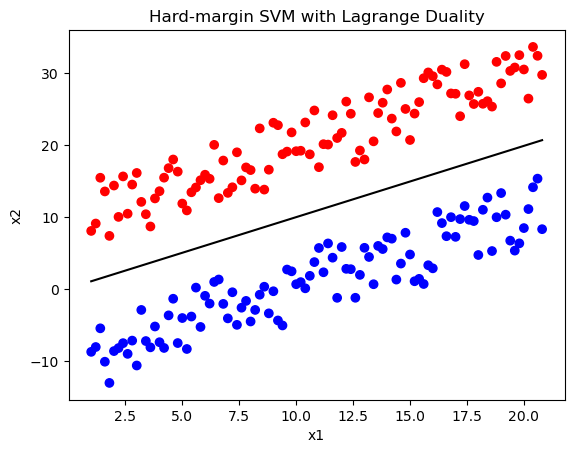

In [8]:
# Load the dataset
data = np.loadtxt('DataSetR2.txt')
X = data[:, :-1]
y = data[:, -1]

# Number of samples
m, n = X.shape

# Construct the matrices for the quadratic programming problem
K = np.dot(X, X.T) * np.outer(y, y)
P = matrix(K)
q = matrix(-np.ones(m))
G = matrix(-np.eye(m))
h = matrix(np.zeros(m))
A = matrix(y, (1, m), 'd')
b = matrix(0.0)

# Solve the quadratic programming problem
solution = solvers.qp(P, q, G, h, A, b)
alphas = np.array(solution['x']).flatten()

# Print the optimal lambda values
print("Optimal lambda values:", alphas)

# Compute w*
w = np.sum(alphas[:, None] * y[:, None] * X, axis=0)

# Support vectors have non-zero lagrange multipliers
support_vectors = np.where(alphas > 1e-5)[0]

# Compute b*
b = np.mean(y[support_vectors] - np.dot(X[support_vectors], w))

# Predict function
def predict(X, w, b):
    return np.sign(np.dot(X, w) + b)

# Predict the class labels for the training data
y_pred = predict(X, w, b)

# Calculate the prediction accuracy
accuracy = np.mean(y_pred == y) * 100
print(f"Prediction accuracy: {accuracy:.2f}%")

# Plot data points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', marker='o')

# Plot the separating hyperplane
x1 = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
x2 = (-w[0] * x1 - b) / w[1]
plt.plot(x1, x2, 'k-')

# Plot support vectors
plt.scatter(X[support_vectors][:, 0], X[support_vectors][:, 1], s=100, facecolors='none')

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Hard-margin SVM with Lagrange Duality')
plt.show()


# HW 4 Set 2 - Problem 3 (Soft Margin SVM Dual)

(a) Use the Lagrange duality to solve the (soft-margin) support vector machine prob-
lem on the “irisversicolorandvirginica.txt”. Your Python program uses
the training data (80% elements of the dataset) to find the separating hyperplane determined by
$w = [w_1, w_2, w_3, w_4, b]$. Then use the test data (20% remaining elements of the dataset) to show the
accuracy of your method.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [21]:
# Load the dataset
data = np.loadtxt('irisversicolorandvirginica.txt')
y = data[:, 0]  # Labels are in the first column
X = data[:, 1:]  # Features are in the remaining columns

# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# dimensions
m, n = X_train.shape

# Regularization parameter
C = 4.0  

# Construct the matrices for the quadratic programming problem
K = np.dot(X_train, X_train.T) * np.outer(y_train, y_train)
P = matrix(K)
q = matrix(-np.ones(m))
G = matrix(np.vstack((-np.eye(m), np.eye(m))))
h = matrix(np.hstack((np.zeros(m), np.ones(m) * C / m)))
A = matrix(y_train, (1, m), 'd')
b = matrix(0.0)

# Solve the quadratic programming problem
solution = solvers.qp(P, q, G, h, A, b)
lambdas = np.array(solution['x']).flatten()

# Print the optimal lambda values
print("Optimal lambda values:", lambdas)

# Compute optimal w solution
w = np.sum(lambdas[:, None] * y_train[:, None] * X_train, axis=0)

# Support vectors have non-zero Lagrange multipliers
support_vectors = np.where(lambdas > 1e-5)[0]

# Compute optimal b solution
b = np.mean(y_train[support_vectors] - np.dot(X_train[support_vectors], w))

# Predict function
def predict(X, w, b):
    return np.sign(np.dot(X, w) + b)

# Predict the class labels for the test data
y_pred = predict(X_test, w, b)

# Calculate the prediction accuracy
accuracy = np.mean(y_pred == y_test) * 100
print(f"Prediction accuracy: {accuracy:.2f}%")

     pcost       dcost       gap    pres   dres
 0: -8.9721e+00 -7.1674e+00  4e+02  2e+01  1e-15
 1: -1.2068e+00 -6.9011e+00  1e+01  4e-01  1e-15
 2: -9.6569e-01 -2.8117e+00  2e+00  9e-17  6e-16
 3: -1.1670e+00 -1.4871e+00  3e-01  7e-17  6e-16
 4: -1.2560e+00 -1.3461e+00  9e-02  8e-17  5e-16
 5: -1.2800e+00 -1.3093e+00  3e-02  7e-17  5e-16
 6: -1.2903e+00 -1.2975e+00  7e-03  8e-17  4e-16
 7: -1.2934e+00 -1.2936e+00  3e-04  8e-17  5e-16
 8: -1.2935e+00 -1.2935e+00  6e-06  1e-16  5e-16
 9: -1.2935e+00 -1.2935e+00  2e-07  9e-17  6e-16
Optimal solution found.
Optimal lambda values: [4.99999993e-02 9.06785587e-10 4.65494528e-10 4.99999989e-02
 4.99999996e-02 4.57515521e-10 3.46747962e-09 5.15980507e-04
 4.99999992e-02 4.99999996e-02 4.99999993e-02 9.57895057e-10
 5.94086583e-09 2.70525852e-08 4.99999978e-02 4.99999965e-02
 3.66180326e-10 4.99999988e-02 6.70676601e-10 4.99999991e-02
 1.88930418e-09 1.38566574e-09 2.79899541e-09 6.54224327e-10
 4.99999996e-02 4.99999986e-02 4.99999992e-02 5.5

(b) Use the kernel method with the Gaussian kernel to solve the problem in part (a).

In [34]:
# Load the dataset
data = np.loadtxt('irisversicolorandvirginica.txt')
y = data[:, 0]  # Labels are in the first column
X = data[:, 1:]  # Features are in the remaining columns

# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# dimensions
m, n = X_train.shape

# Regularization parameter
C = 4.0  

# Kernel function (RBF kernel)
def rbf_kernel(X, Y, gamma=0.5):
    K = np.exp(-gamma * np.linalg.norm(X[:, np.newaxis] - Y[np.newaxis, :], axis=2) ** 2)
    return K

# Number of training samples
m, n = X_train.shape

# Regularization parameter
C = 4.0  # You can adjust this parameter

# Construct the matrices for the quadratic programming problem using the RBF kernel
K_train = rbf_kernel(X_train, X_train)
P = matrix(np.outer(y_train, y_train) * K_train)
q = matrix(-np.ones(m))
G = matrix(np.vstack((-np.eye(m), np.eye(m))))
h = matrix(np.hstack((np.zeros(m), np.ones(m) * C / m)))
A = matrix(y_train, (1, m), 'd')
b = matrix(0.0)

# Solve the quadratic programming problem
solution = solvers.qp(P, q, G, h, A, b)
lambdas = np.array(solution['x']).flatten()

# Print the optimal lambda values
print("Optimal lambda values:", lambdas)

# Support vectors have non-zero Lagrange multipliers
support_vectors = np.where(lambdas > 1e-5)[0]

# Compute the bias term b*
b = np.mean([y_train[i] - np.sum(lambdas * y_train * K_train[:, i]) for i in support_vectors])

# Predict function using the kernel
def predict(X_train, y_train, X_test, lambdas, b, kernel, gamma=0.5):
    K_test = kernel(X_train, X_test, gamma)
    y_pred = np.sign(np.sum((lambdas * y_train)[:, np.newaxis] * K_test, axis=0) + b)
    return y_pred

# Predict the class labels for the test data
y_pred = predict(X_train, y_train, X_test, lambdas, b, rbf_kernel)

# Calculate the prediction accuracy
accuracy = np.mean(y_pred == y_test) * 100
print(f"Prediction accuracy: {accuracy:.2f}%")

     pcost       dcost       gap    pres   dres
 0: -9.1385e+00 -9.8683e+00  4e+02  2e+01  5e-16
 1: -3.9964e+00 -8.6016e+00  2e+01  7e-01  5e-16
 2: -2.8134e+00 -5.5151e+00  3e+00  1e-16  2e-15
 3: -3.0365e+00 -3.2348e+00  2e-01  8e-17  6e-16
 4: -3.1388e+00 -3.1445e+00  6e-03  8e-17  5e-16
 5: -3.1428e+00 -3.1429e+00  6e-05  9e-17  5e-16
 6: -3.1429e+00 -3.1429e+00  6e-07  1e-16  5e-16
Optimal solution found.
Optimal lambda values: [0.05       0.05       0.05       0.05       0.05       0.04999999
 0.05       0.05       0.04999995 0.04999999 0.04999999 0.04999999
 0.04999997 0.05       0.04999997 0.04999999 0.04999999 0.05
 0.05       0.04999994 0.04999998 0.05       0.05       0.04999998
 0.04999998 0.04999997 0.04999998 0.05       0.05       0.04999999
 0.04999999 0.05       0.05       0.05       0.04999996 0.05
 0.04999999 0.04999999 0.04999999 0.04999998 0.04999997 0.04999999
 0.04999999 0.04999996 0.04999999 0.04999999 0.05       0.05
 0.05       0.04999999 0.04999999 0.05      